In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

D0815 12:39:56.963013947      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0815 12:39:56.963041575      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0815 12:39:56.963045765      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0815 12:39:56.963049097      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0815 12:39:56.963052189      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0815 12:39:56.963055695      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0815 12:39:56.963058749      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0815 12:39:56.

In [3]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


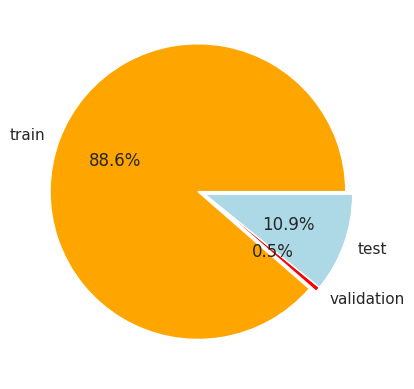

In [4]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [5]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


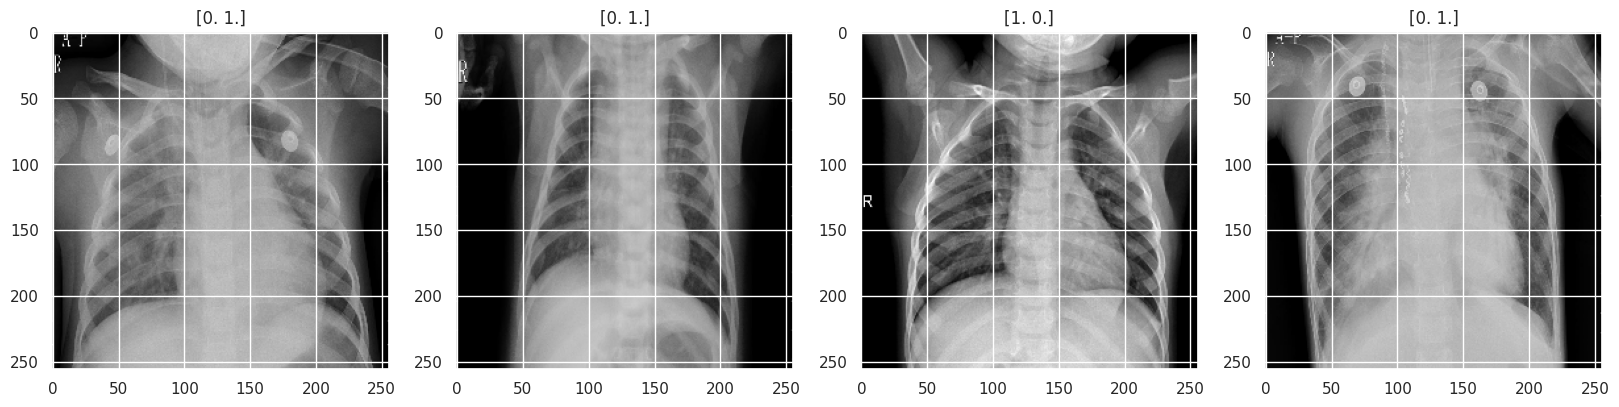

In [6]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
# Extracting Features and Labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [8]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [9]:
# Pixel Value Scaling for Datasets: Normalizing and Standardizing the Data
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

In [10]:
# We use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                         

In [11]:
hist = model.fit(x_train, y_train, epochs= epochs, validation_data= (x_val, y_val))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/10
163/163 [==============================] - 180s 1s/step - loss: 1.0017 - accuracy: 0.8850 - val_loss: 0.3942 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 178s 1s/step - loss: 0.2026 - accuracy: 0.9638 - val_loss: 0.3251 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 179s 1s/step - loss: 0.1720 - accuracy: 0.9732 - val_loss: 0.0705 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 178s 1s/step - loss: 0.0939 - accuracy: 0.9816 - val_loss: 0.4172 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 178s 1s/step - loss: 0.1453 - accuracy: 0.9806 - val_loss: 0.0666 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 181s 1s/step - loss: 0.0837 - accuracy: 0.9864 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 181s 1s/step - loss: 0.0709 - accuracy: 0.9900 - val_loss: 0.3531 - val_accuracy: 0.9375

<a id="7"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model </p>
<a class="btn" href="#home">Tabel of Contents</a>

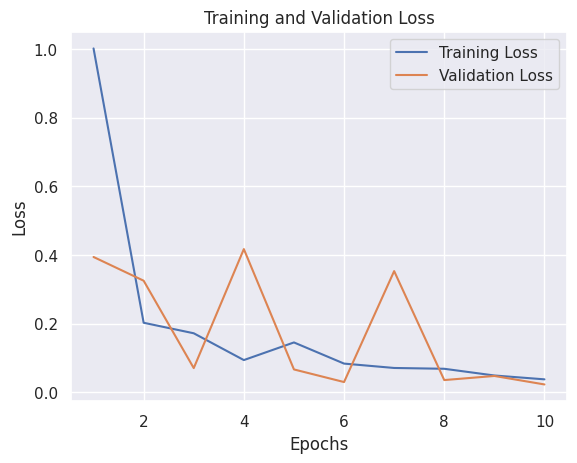

In [12]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

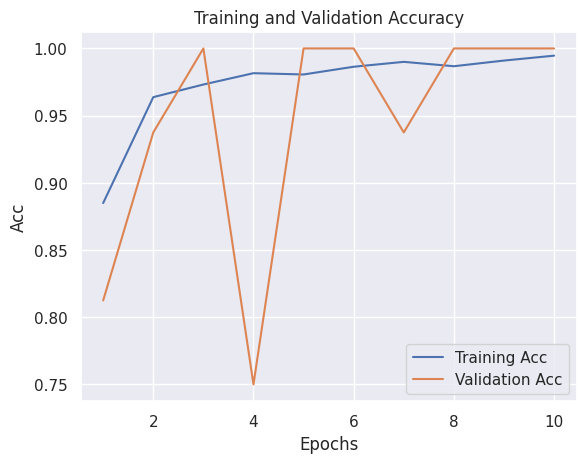

In [13]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
